# Fertility Prediction Model

## Libraries and Data

In [31]:
#load in libraries 
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# clustering for data examination
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.linear_model import LinearRegression as LM
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import AdaBoostClassifier as AdBoost
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.linear_model import Lasso
from sklearn.svm import LinearSVC
from sklearn.svm import SVC


# For evaluating our model's performance
import sklearn.metrics as m
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# sampling 
from imblearn.over_sampling import RandomOverSampler

In [32]:
fertility = pd.read_csv('Data/API_SP.DYN.TFRT.IN_DS2_en_csv_v2_3932080.csv')
pop = pd.read_excel('Data/POP.TOTL.xlsx')
gdp = pd.read_csv('Data/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_3930492.csv')
lfexp = pd.read_csv('Data/life expectancy.csv')
urbn = pd.read_csv('Data/Urban Pop.csv')
pleave = pd.read_excel('Data/parental leave.xlsx')
femtrvl = pd.read_excel('Data/FemTravel.xlsx')
femdiv = pd.read_excel('Data/FemDivorce.xlsx')
fembank = pd.read_excel('Data/FemBank.xlsx')

## Preprocessing Data Format

### Dropping

In [33]:
# dropping columns for the melt
wbank_fert = fertility.drop(columns=['Indicator Code','Indicator Name','Unnamed: 65'],axis = 1)
pop = pop.drop(columns=['Indicator Code','Indicator Name'],axis = 1)
gdp = gdp.drop(columns=['Indicator Code','Indicator Name'],axis = 1)
lfexp = lfexp.drop(columns=['Indicator Code','Indicator Name'],axis = 1)
urbn = urbn.drop(columns=['Series Code','Series Name'],axis = 1)
pleave = pleave.drop(columns=['Series Code','Series Name'],axis = 1)
femtrvl = femtrvl.drop(columns=['Series Code','Series Name'],axis = 1)
femdiv = femdiv.drop(columns=['Series Code','Series Name'],axis = 1)
fembank = fembank.drop(columns=['Series Code','Series Name'],axis = 1)

### Format Adjustment

In [34]:
## Melting
# melt world bank data
wbank_fert = wbank_fert.melt(id_vars = ['Country Name','Country Code'], var_name = 'Year', value_name='Fertility Value')
pop = pop.melt(id_vars = ['Country Name','Country Code'], var_name = 'Year', value_name='Population/1000')
gdp = gdp.melt(id_vars = ['Country Name','Country Code'], var_name = 'Year', value_name='pcap GDP')
lfexp = lfexp.melt(id_vars = ['Country Name','Country Code'], var_name = 'Year', value_name='Life Expectancy at Birth')
urbn = urbn.melt(id_vars = ['Country Name','Country Code'], var_name = 'Year', value_name='% Urban pop')
pleave = pleave.melt(id_vars = ['Country Name','Country Code'], var_name = 'Year', value_name='Paid Parental Leave')
femtrvl = femtrvl.melt(id_vars = ['Country Name','Country Code'], var_name = 'Year', value_name='FemTravel')
femdiv = femdiv.melt(id_vars = ['Country Name','Country Code'], var_name = 'Year', value_name='FemDiv')
fembank = fembank.melt(id_vars = ['Country Name','Country Code'], var_name = 'Year', value_name='FemBankAccnt')

In [35]:
## scale column
holder = []
for x in pop['Population/1000']:
    holder.append(x/1000) 
# add in column
pop['Population/1000'] = holder

In [36]:
## Column Formatting
#convert years to standard form
holder = []
for x in pop['Year']:
    holder.append(int(x))
pop['Year'] = holder

#repeat for other years
holder = []
for x in wbank_fert['Year']:
    holder.append(int(x))
wbank_fert['Year'] = holder

# drop prevents failure in below chunk
lfexp = lfexp.dropna()
holder = []
for x in lfexp['Year']:
    holder.append(int(x))
lfexp['Year'] = holder

# drop prevents failure in below chunk
gdp = gdp.dropna()
holder = []
for x in gdp['Year']:
    holder.append(int(x))
gdp['Year'] = holder

In [37]:
# define function to split str and extract year value
def seryear(t):
    t = t.split()
    t = int(t[0])
    return t

# apply function in loops
holder = []
for x in urbn['Year']:
    holder.append(seryear(x))
urbn['Year'] = holder

holder = []
for x in pleave['Year']:
    holder.append(seryear(x))
pleave['Year'] = holder

holder = []
for x in femtrvl['Year']:
    holder.append(seryear(x))
femtrvl['Year'] = holder

holder = []
for x in femdiv['Year']:
    holder.append(seryear(x))
femdiv['Year'] = holder

holder = []
for x in fembank['Year']:
    holder.append(seryear(x))
fembank['Year'] = holder

### Add in variables

In [38]:
#reshape gdp
gdp['logpercapGDP'] = np.log10(gdp['pcap GDP'])

# sq population and life expectancy
pop['(Population/1000)^2'] = np.square(pop['Population/1000'])
lfexp['Life Exp Sq'] = np.square(lfexp['Life Expectancy at Birth'])

#### Creating the outcomes

In [39]:
# create future values through a groupyby shift by 8 years
wbank_fert['Future Fertility'] = wbank_fert.groupby(['Country Name'])['Fertility Value'].shift(-8)


# create relavent binaries 
repholder = []
lowholder = []
for x in wbank_fert['Future Fertility']:
# check for replacement rate
    if x >= 2.1:
        repholder.append(1)
    else:
        repholder.append(0)
# check low fertility rate
    if x >= 1.3:
        lowholder.append(1)
    else:
        lowholder.append(0)

# add in new columns    
wbank_fert['Replacement Reached'] = repholder
wbank_fert['Low Surpassed'] = lowholder

## Merge

In [45]:
#create a merger key
merger = ['Country Code','Year']

#left merge worldbank data
dta = pd.merge(wbank_fert,pop, on=merger, how='left')

# continue merging
dta = pd.merge(dta,gdp, on=merger, how='left')
dta = pd.merge(dta,lfexp, on=merger, how='left')
dta = pd.merge(dta,urbn, on=merger, how='left')
dta = pd.merge(dta,femtrvl, on=merger, how='left')
dta = pd.merge(dta,pleave, on=merger, how='left')
dta = pd.merge(dta,femdiv, on=merger, how='left')
dta = pd.merge(dta,fembank, on=merger, how='left')


## Preprocess Data

In [64]:
# clean up
clndta = dta.drop(columns=['Country Name_y','Country Name_x','Country Name_y','Country Name'],axis = 1)
# clean data will lack nas for desired y values
clndta = clndta.dropna()
clndta.head()

,Country Code,Year,Fertility Value,Future Fertility,Replacement Reached,Low Surpassed,Population/1000,(Population/1000)^2,pcap GDP,logpercapGDP,Life Expectancy at Birth,Life Exp Sq,% Urban pop,FemTravel,Paid Parental Leave,FemDiv,FemBankAccnt
2,AFG,1960,7.450,7.450,1,1,8996.967,8.094542e+07,59.773234,1.776507,32.446000,1052.742916,8.401,0.0,0.0,0.0,1.0
13,AUS,1960,3.453,2.888,1,1,10276.477,1.056060e+08,1810.619230,3.257827,70.817073,5015.057852,81.529,0.0,0.0,1.0,1.0
14,AUT,1960,2.690,2.580,1,1,7047.539,4.966781e+07,935.460427,2.971025,68.585610,4703.985866,64.720,1.0,0.0,1.0,1.0
16,BDI,1960,6.944,7.227,1,1,2797.925,7.828384e+06,70.051910,1.845420,41.281000,1704.120961,2.077,1.0,0.0,0.0,1.0
17,BEL,1960,2.540,2.310,1,1,9153.489,8.378636e+07,1273.691659,3.105064,69.701951,4858.362004,92.460,1.0,0.0,1.0,0.0


### Explore possible grouping

In [73]:
#create femdta to see if they may be grouped
femdta = clndta.drop(columns=['Country Code','Replacement Reached','Low Surpassed','Future Fertility','Population/1000',
'(Population/1000)^2','pcap GDP','Life Expectancy at Birth','Life Exp Sq','% Urban pop','Year','logpercapGDP'])

femdta.head()


,Fertility Value,logpercapGDP,FemTravel,Paid Parental Leave,FemDiv,FemBankAccnt
2,7.450,1.776507,0.0,0.0,0.0,1.0
13,3.453,3.257827,0.0,0.0,1.0,1.0
14,2.690,2.971025,1.0,0.0,1.0,1.0
16,6.944,1.845420,1.0,0.0,0.0,1.0
17,2.540,3.105064,1.0,0.0,1.0,0.0


In [74]:
#loop to check clusters
SSEval = []
Silval = []
for i in range(2,6):
    sil = []
#create object
    km = KMeans(n_clusters=i, init='random', random_state=0)
#fit object
    km.fit_predict(femdta)
#append SSE
    SSEval.append(km.inertia_)
#create silhouette value
    sil = silhouette_score(femdta,km.fit_predict(femdta))
#append silval
    Silval.append(sil)

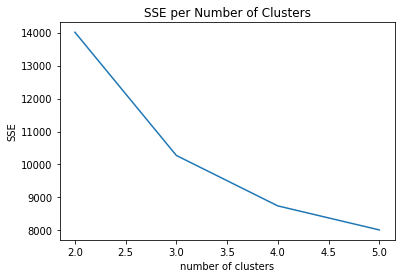

In [75]:
#plot the code
plt.plot(range(2,6),SSEval)
plt.xlabel('number of clusters')
plt.ylabel('SSE')
plt.title('SSE per Number of Clusters')
plt.show()


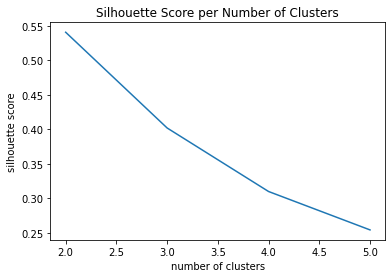

In [76]:
#plot the code
plt.plot(range(2,6),Silval)
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.title('Silhouette Score per Number of Clusters')
plt.show()

In [ ]:
##standardize data
#create scale object
scaler = pp.StandardScaler()
#drop unstandardable columns
nums = clndta.drop(columns=['Country Code','Year','Replacement Reached','Low Surpassed','Paid Parental Leave','FemTravel','FemDiv','FemBankAccnt'])
#apply scaler to laoded data
stndta = pd.DataFrame.from_records(scaler.fit_transform(nums),
        columns = ['Fertility Value','Future Fertility','Population/1000','(Population/1000)^2','pcap GDP','logpercapGDP','Life Expectancy at Birth','Life Exp Sq','% Urban pop'])

In [ ]:
#add standardized data back in 


## Splitting

In [ ]:
# set the seed
np.random.seed(770)

# create x and y 
Fertvals = stndta['Future Fertility']
replvl = stndta['Replacement Reached']
x = stndta.drop(columns=['Future Fertility','Replacement Reached','Low Surpassed','Country Code','Year'])

### Balance Check

In [ ]:
stndta['Low Surpassed'].value_counts()

1    7486
0     213
Name: Low Surpassed, dtype: int64

In [ ]:
stndta['Replacement Reached'].value_counts()

1    5491
0    2208
Name: Replacement Reached, dtype: int64

In [ ]:
# rep data split
xrep_train, xrep_test, yrep_train, yrep_test = train_test_split(x,replvl,
                                                    test_size=0.2,
                                                    random_state=770)

# fert data split
xfert_train, xfert_test, yfert_train, yfert_test = train_test_split(x,Fertvals,
                                                    test_size=0.2,
                                                    random_state=770)                

In [ ]:
## low data split with over sampling
#define the y
lowlvl = stndta['Low Surpassed']
#initiate oversample
over = RandomOverSampler(random_state=770)

# oversample to prevent data loss
ovlowx, ovlowy = over.fit_resample(x,lowlvl)

#split
xlow_train, xlow_test, ylow_train, ylow_test = train_test_split(ovlowx,ovlowy,
                                                    test_size=0.2,
                                                    random_state=770)


## Distribution Check

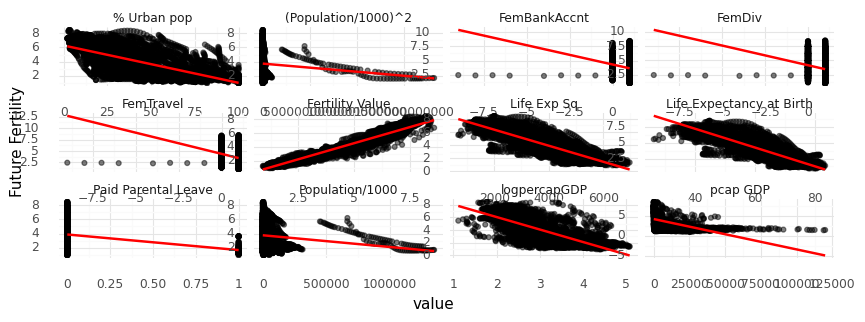

<ggplot: (151562001845)>

In [ ]:
#check distributions
dist = xfert_train.copy()
dist['Future Fertility'] = yfert_train

(
    ggplot(dist.melt(id_vars=["Future Fertility"]),
           aes(x="value",y="Future Fertility"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)


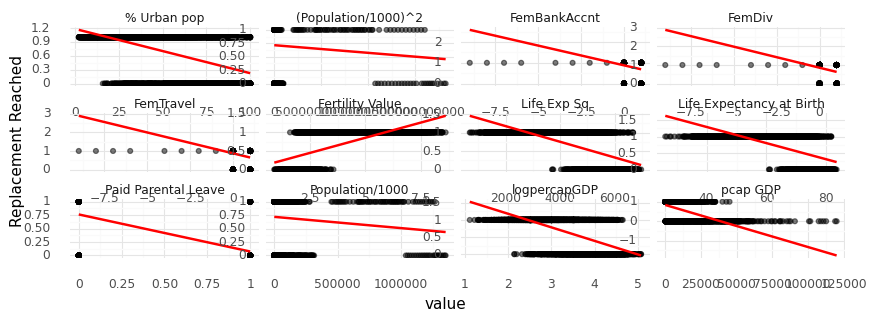

<ggplot: (151565166565)>

In [ ]:
#check distributions
dist = xrep_train.copy()
dist['Replacement Reached'] = yrep_train

(
    ggplot(dist.melt(id_vars=["Replacement Reached"]),
           aes(x="value",y="Replacement Reached"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)


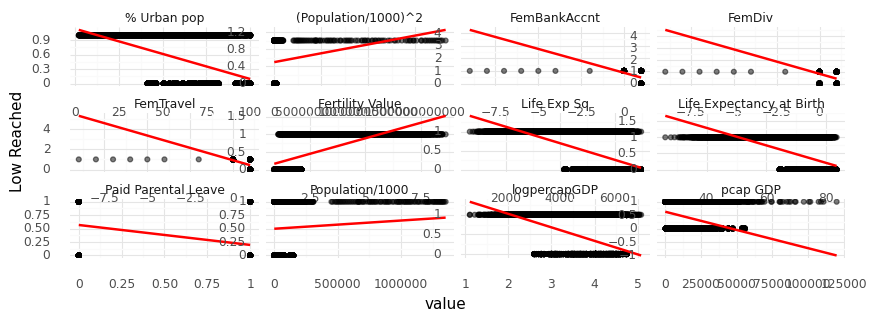

<ggplot: (151568472055)>

In [ ]:
#check distributions
dist = xlow_train.copy()
dist['Low Reached'] = ylow_train

(
    ggplot(dist.melt(id_vars=["Low Reached"]),
           aes(x="value",y="Low Reached"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)


## Pipeline

In [ ]:
#fold generated with 6 folds
fold_generator = KFold(n_splits=6, shuffle=True,random_state=770)

#set the pipe
pipe1 = Pipeline(steps=[('model',None)])

### Fertility Rate Model

In [ ]:
#define non binary search space
numsearch_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # Logistic Model
    {'model' : [LogisticRegression()]},

    # Lasso Model
    {'model' : [Lasso()],
     'model__alpha':[.5,1]},
    
    # NaiveBayes
    {'model' : [NB()]},

    # AdaBoost
    {'model' : [AdBoost()],
     'model__n_estimators' : [180,200,250,300,500]},

    # SVM
    {'model' : [SVC()],
     'model__C':[1],
     'model__probability':[False]},

    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[30,35,42,50,75,125,150]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[3,4,5,6,7,8]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[200,250,300,500,1000]},
]

In [ ]:
#fit model to data, based on different scoring mechanisms 
searchfert = GridSearchCV(pipe1, numsearch_space, 
                      cv = fold_generator,
                      scoring= 'neg_mean_squared_error',
#                      scoring= 'f1',
                      n_jobs=5)
searchfert.fit(xfert_train,yfert_train)
searchfert.best_estimator_

Pipeline(steps=[('model', BaggingRegressor())])

### Binary Modeling 

In [ ]:
# define binary variable search space
bisearch_space1 = [
    # Linear Model
    {'model' : [LM()]},
    
    # Logistic Model
    {'model' : [LogisticRegression()]},

    # Lasso Model
    {'model' : [Lasso()],
     'model__alpha':[.5,1]},
    
    # NaiveBayes
    {'model' : [NB()]},

    #SVM
    {'model' : [SVC()],
     'model__C':[1],
     'model__probability':[True]},

    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[30,35,42,50,75,125,150]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[3,4,5,6,7,8]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[200,250,300,500,1000]},
]

In [ ]:
#fit model to data, based on different scoring mechanisms 
searchrep = GridSearchCV(pipe1, bisearch_space1, 
                      cv = fold_generator,
#                      scoring= 'neg_mean_squared_error',
                      scoring= 'roc_auc',
                      n_jobs=5)
searchrep.fit(xrep_train,yrep_train)
repmod = searchrep.best_estimator_
repmod

KeyboardInterrupt: 

In [ ]:
vi = permutation_importance(repmod,xrep_train,yrep_train,n_repeats=5)
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=xrep_train.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat1 = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)

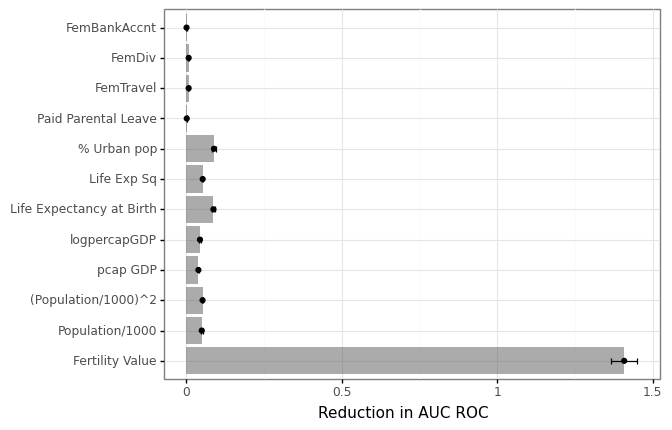

<ggplot: (137937980164)>

In [ ]:
#plot results
(
    ggplot(vi_dat1,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [ ]:
#fit model to data, based on different scoring mechanisms 
searchlow = GridSearchCV(pipe1, bisearch_space1, 
                      cv = fold_generator,
#                      scoring= 'neg_mean_squared_error',
#                      scoring= 'f1',
#                      scoring= 'recall',
                      scoring= 'roc_auc',
                      n_jobs=5)
searchlow.fit(xlow_train,ylow_train)
searchlow.best_estimator_

Pipeline(steps=[('model', BaggingRegressor())])

## Robustness

### Fertility Robustness Check

In [ ]:
#create predictions
fertpred = searchfert.predict(xfert_test)
# R2 score check

fertscor = m.r2_score(yfert_test,fertpred)
fertscor

0.985697253655659

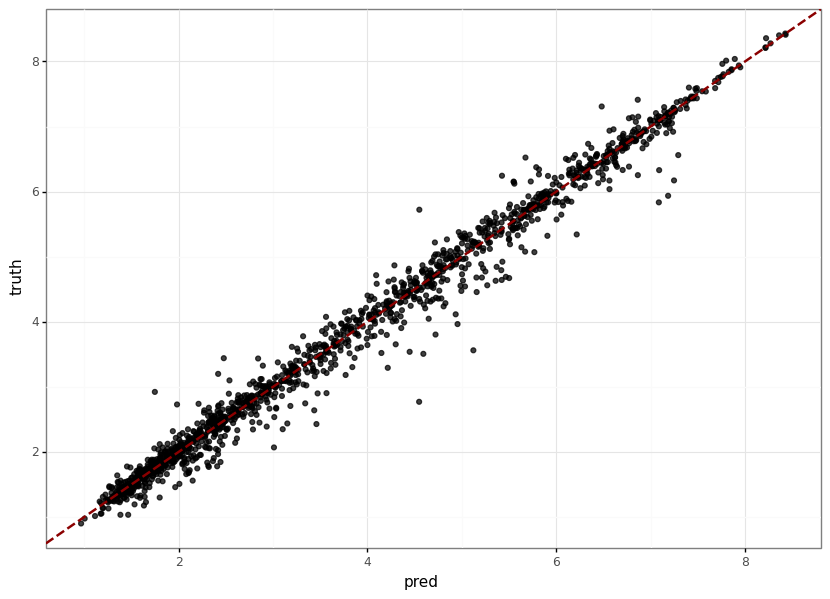

<ggplot: (137948003024)>

In [ ]:
(
    ggplot(pd.DataFrame(dict(pred=fertpred,truth=yfert_test)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)


### Replacement Robust Check

In [ ]:
repscor = searchrep.score(xrep_test,yrep_test)
repscor

0.9889922799494748

In [ ]:
#create true predictions
reppred = searchrep.predict(xrep_test)
# round for matrix
reppred1 = reppred.round()

# run matrix
pd.DataFrame(confusion_matrix(yrep_test, reppred1),
            columns=["Predicted negative", "Predicted positive"],
            index=["Actual negative","Actual positive"]).style.background_gradient(cmap="PiYG")

,Predicted negative,Predicted positive
Actual negative,405,31
Actual positive,20,1084


### Low Fertility Robustness Check

In [ ]:
lowscor = searchlow.score(xlow_test,ylow_test)
lowscor

0.9993211133740665

In [ ]:
#create true predictions
lowpred = searchlow.predict(xlow_test)
# round for matrix
lowpred1 = lowpred.round()

# run matrix
pd.DataFrame(confusion_matrix(ylow_test, lowpred1),
            columns=["Predicted negative", "Predicted positive"],
            index=["Actual negative","Actual positive"]).style.background_gradient(cmap="PiYG")

,Predicted negative,Predicted positive
Actual negative,1522,0
Actual positive,11,1462
